In [1]:
import os 
os.chdir('../')

In [2]:
from backbones.DiT import DiT

# 사용 예
model = DiT()
print(model)

/home/scpark/miniconda3/envs/sana/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/home/scpark/miniconda3/envs/sana/lib/python3.10/site-packages/xformers/ops/fmha/flash.py:211: FutureWarning: `torch.library.impl_abstract` was renamed to `torch.library.register_fake`. Please use that instead; we will remove `torch.library.impl_abstract` in a future version of PyTorch.
  @torch.library.impl_abstract("xformers_flash::flash_fwd")
/home/scpark/miniconda3/envs/sana/lib/python3.10/site-packages/xformers/ops/fmha/flash.py:344: FutureWarning: `torch.library.impl_abstract` was renamed to `torch.library.register_fake`. Please use that instead; we will remove `torch.library.impl_abstract` in a future version of PyTorch.
  @torch.library.impl_abstract("xformers_flash::flash_bwd")
Loading pipeline components...:   0%

In [8]:
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image

def display_class_images(pixel_samples, class_ids=None, figsize_per_image=1.5):
    """
    pixel_samples: List of PIL.Image.Image 또는 array/tensor 형태 이미지
    class_ids:     레이블 리스트. 없으면 0,1,2,...
    figsize_per_image: 각 이미지당 크기 비율 (inches)
    """
    samples = list(pixel_samples)
    processed = []
    for img in samples:
        # 1) PIL Image → np.array
        if isinstance(img, Image.Image):
            arr = np.array(img)
        else:
            # 2) tensor or ndarray → np.array
            arr = np.array(img)
            # (C,H,W) 형태면 (H,W,C)로 변환
            if arr.ndim == 3 and arr.shape[0] in (1,3):
                arr = arr.transpose(1, 2, 0)
        processed.append(arr)

    n = len(processed)
    if class_ids is None:
        class_ids = list(range(n))

    fig, axes = plt.subplots(1, n, figsize=(n * figsize_per_image, figsize_per_image))
    if n == 1:
        axes = [axes]
    for ax, img_arr, lbl in zip(axes, processed, class_ids):
        ax.imshow(img_arr)
        ax.axis("off")
        ax.set_title(f"Class {lbl}", fontsize=8)
    plt.tight_layout()
    plt.show()


100%|██████████| 19/19 [00:00<00:00, 24.04it/s]


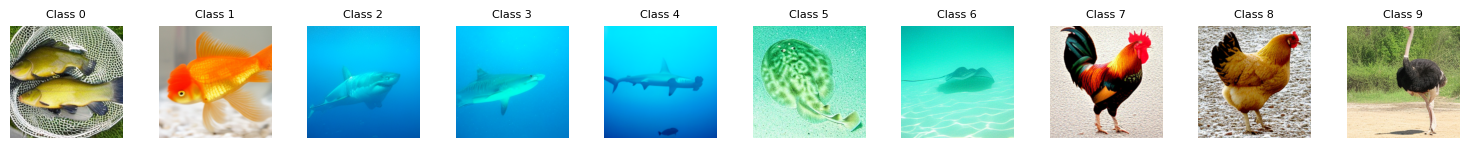

In [11]:
from solvers.dpm_solver import DPM_Solver

# 클래스 0–9로 설정
class_ids = list(range(10))
model_fn, noise_schedule, latents = model.get_model_fn(class_ids=class_ids,
                                                       guidance_scale=3.0,
                                                       seed=42)
solver = DPM_Solver(model_fn, noise_schedule, algorithm_type="dpmsolver++")
latent_samples = solver.sample(latents, steps=20, order=2,
                               skip_type="time_uniform",
                               method="multistep")
pixel_samples = model.decode_vae(latent_samples)

# 방금 만든 함수로 한 줄에 쫘악 출력
display_class_images(pixel_samples, class_ids)
